# Heuristic Optimization

In [1]:
import soiling_model as sm
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import (rcParams,dates,colors)
rcParams['figure.figsize'] = (15, 7)

In [2]:
d = "data/public/" 
params = d+"parameters.xlsx"
weather = d+'woomera_data.xlsx'
SF = d+'SF_woomera_SolarPILOT.csv'            # solar field of 48 sectors located in Woomera
climate_file = d+'woomera_location_modified.epw'
n_az = 8        # number of azimuth partitions for the field sectors
n_rad = 6       # number of radial partitions for the field sectors
n_sol_az = 10   # number of solar azimuth angles for the efficiency lookup table
n_sol_el = 10   # number of solar elevation angles for the efficiency lookup table
second_surface = False # second_surface = False uses a first-surface model for the reflectance loss
number_of_sectors_cleaned_per_truck = 1 # number of sectors cleaned in a day by one truck

Build soiling model, import inputs, and sectorize the field

Importing constants
Importing dust
Importing full solar field and sectorizing with 8 angular and 6 radial sectors
Importing site data (weather,time). Using dust_type = PM10, test_length = 8760 hours
Length of simulation for file data/public/woomera_data.xlsx: 365.0 days
No rain intensity data to import.
Calculating sun apparent movement and angles for 1 simulations
Calculating heliostat movement and angles for 1 simulations
First surface model
No value for hrz0 supplied. Using value in self.hrz0 = 50.0.
Calculating deposition velocity for each of the 1 simulations
Calculating adhesion/removal balance
  Using common stow_tilt. Assumes all heliostats are stored at helios.stow_tilt at night.
Calculating soil deposited in a timestep [m^2/m^2]
Getting efficiencies for az=0.000, el=10.000
Power absorbed by receiver at DNI=1000 W/m2: 4.10e+05 kW
Getting efficiencies for az=0.000, el=18.889
Power absorbed by receiver at DNI=1000 W/m2: 5.63e+05 kW
Getting efficiencies for az=0.000, el=27.778
Po

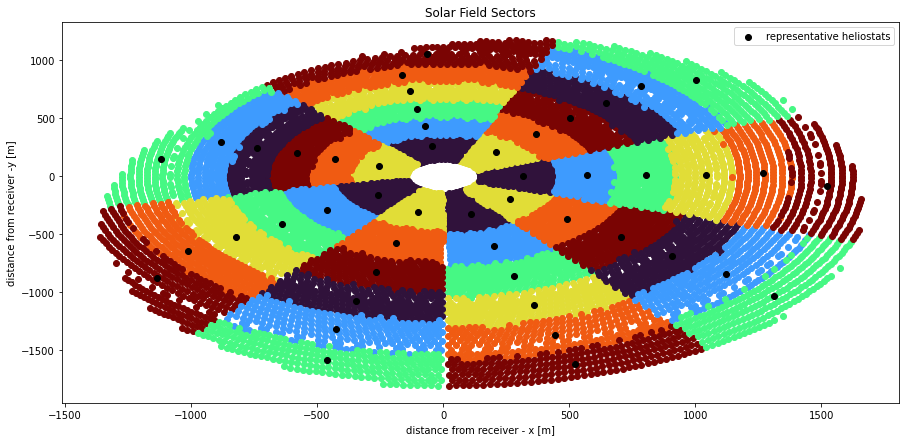

In [3]:
sec = (n_rad,n_az)
opt = sm.cleaning_optimisation(params,SF,weather,climate_file,sec,dust_type="PM10",\
    second_surface=second_surface,n_az=n_sol_az,n_el=n_sol_el)
sim_data = sm.simulation_inputs(weather,dust_type="PM10")
opt.field_model.helios.sector_plot()

Grid search number of trucks and annual cleans to optimize cleaning resources and frequencies.

In [4]:
helio_area = opt.field_model.helios.height*opt.field_model.helios.width
n_helios = opt.field_model.helios.full_field['x'].shape[0]
area_per_sector = n_helios/n_az/n_rad*helio_area
opt.truck = {   'operator_salary':80e3,
                'operators_per_truck_per_day':4,
                'purchase_cost':150e3,
                'maintenance_costs':15e3,
                'useful_life': 4,
                'fuel_cost': 0.005*area_per_sector,
                'water_cost': 0.005*area_per_sector
            }
opt.electricty_price = 50/1e6
opt.plant_other_maintenace = 0.0
opt.plant.receiver['thermal_max'] = 1e3 # MW
opt.plant.receiver['thermal_min'] = 105 # MW

Optimize via grid search on number of trucks and number of field cleans in a year

In [5]:
Nt = range(1,10)
Nc = range(1,51)
TCC = np.nan*np.ones((len(Nt),len(Nc)))
for ii in range(len(Nt)):
    n_trucks = Nt[ii]
    for jj in range(len(Nc)):
        n_cleans = Nc[jj]
        print("Simulating {0:d} trucks with {1:d} cleans".format(n_trucks,n_cleans))
        results = opt.compute_total_cleaning_costs(sim_data,n_trucks,n_cleans,\
            n_sectors_per_truck=number_of_sectors_cleaned_per_truck,verbose=False)
        number_of_cleaning_finishes = results['cleaning_actions'][0].sum(axis=1)[-1]
        if  number_of_cleaning_finishes < n_cleans:
            print("Cleans maxed out")
            break
        else:
            TCC[ii,jj] = results['total_cleaning_costs']

Simulating 1 trucks with 1 cleans
Simulating 1 trucks with 2 cleans
Simulating 1 trucks with 3 cleans
Simulating 1 trucks with 4 cleans
Simulating 1 trucks with 5 cleans
Simulating 1 trucks with 6 cleans
Simulating 1 trucks with 7 cleans
Simulating 1 trucks with 8 cleans
Cleans maxed out
Simulating 2 trucks with 1 cleans
Simulating 2 trucks with 2 cleans
Simulating 2 trucks with 3 cleans
Simulating 2 trucks with 4 cleans
Simulating 2 trucks with 5 cleans
Simulating 2 trucks with 6 cleans
Simulating 2 trucks with 7 cleans
Simulating 2 trucks with 8 cleans
Simulating 2 trucks with 9 cleans
Simulating 2 trucks with 10 cleans
Simulating 2 trucks with 11 cleans
Simulating 2 trucks with 12 cleans
Simulating 2 trucks with 13 cleans
Simulating 2 trucks with 14 cleans
Simulating 2 trucks with 15 cleans
Simulating 2 trucks with 16 cleans
Cleans maxed out
Simulating 3 trucks with 1 cleans
Simulating 3 trucks with 2 cleans
Simulating 3 trucks with 3 cleans
Simulating 3 trucks with 4 cleans
Simulat

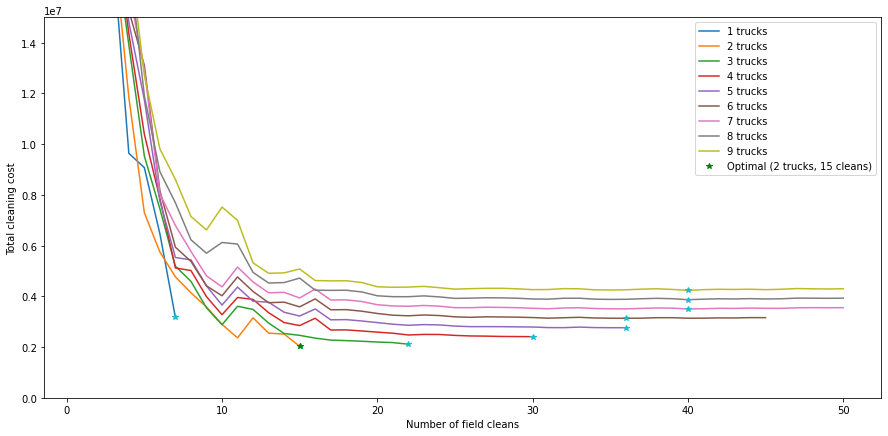

In [6]:
fig,ax = plt.subplots()
num_cleans = np.arange(start=Nc[0],stop=Nc[-1]+1)
for ii in Nt:
    ax.plot(num_cleans,TCC[ii-1,:],label=str(ii)+" trucks")

# optimal for each number of trucks
nc_opt = np.nanargmin(TCC,axis=1)
ax.plot(num_cleans[nc_opt],TCC[range(len(Nt)),nc_opt],linestyle="None",marker='*')

# overall optimal
nc_opt = np.nanargmin(TCC)
r,c = np.unravel_index(nc_opt,TCC.shape)
label_str = "Optimal ({0:d} trucks, {1:d} cleans)".format(r+1,c+1)
ax.plot(num_cleans[c],TCC[r,c],color='green',linestyle="None",marker='*',label=label_str)

ax.set_xlabel("Number of field cleans")
ax.set_ylabel("Total cleaning cost")
ax.set_ylim((0,15e6))
ax.legend()

Calculating reflectance losses with cleaning for 1 simulations
Number of time steps where sun is above stow elevation:3752.0 (10.0 degrees)
Number of time steps where clean receiver would be on: 3038
Number of time steps where actual receiver is on: 3026
Number of time steps where clean receiver would be saturated: 0
Number of time steps where actual receiver is saturated: 0
Results for simulation 0: 
  TCC: 2.03e+06
  C_deg: 1.10e+06
  C_cl: 9.33e+05


720.0

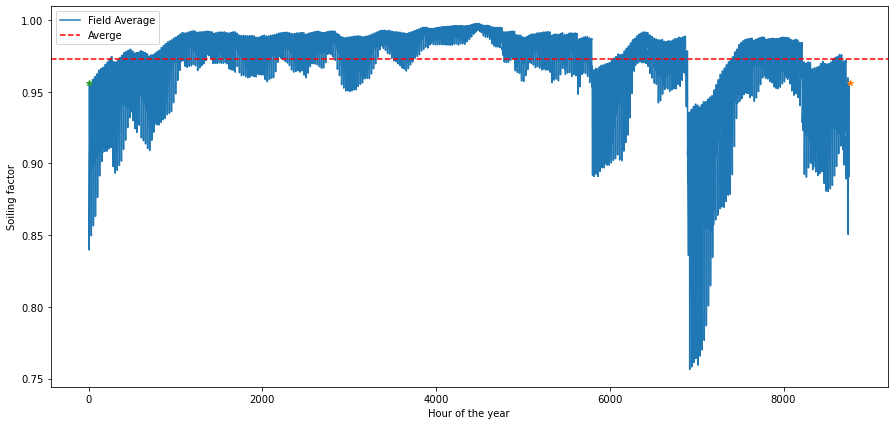

In [7]:
results_opt = opt.compute_total_cleaning_costs(sim_data,r+1,c+1,\
    n_sectors_per_truck=number_of_sectors_cleaned_per_truck,verbose=True)
nh,nt = results['soiling_factor'][0].shape
fig,ax = plt.subplots()
sf = results['soiling_factor'][0]
ax.plot(sf.mean(axis=0),label="Field Average")
ax.plot(nt-1,sf[:,0].mean(),'*')
ax.plot(0,sf[:,-1].mean(),'*')
ax.axhline(y=sf.mean(),color='red',ls='--',label="Averge")
ax.set_xlabel("Hour of the year")
ax.set_ylabel("Soiling factor")
ax.legend()
results_opt['cleaning_actions'][0].sum()


Results for optimum

In [8]:
results = opt.compute_total_cleaning_costs(sim_data,r+1,c+1,verbose=True)
"Number of cleans: {0:.1f}".format(results['cleaning_actions'][0].sum())

Calculating reflectance losses with cleaning for 1 simulations
Number of time steps where sun is above stow elevation:3752.0 (10.0 degrees)
Number of time steps where clean receiver would be on: 3038
Number of time steps where actual receiver is on: 3026
Number of time steps where clean receiver would be saturated: 0
Number of time steps where actual receiver is saturated: 0
Results for simulation 0: 
  TCC: 2.03e+06
  C_deg: 1.10e+06
  C_cl: 9.33e+05


'Number of cleans: 720.0'

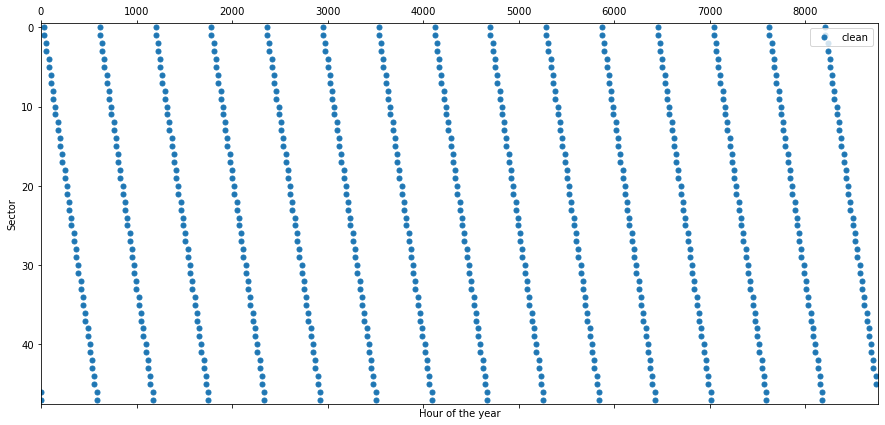

In [9]:
N_sectors = n_az*n_rad
cleans = sm.simple_annual_cleaning_schedule(N_sectors,r+1,c+1)
ax = plt.subplot()
ax.spy(cleans,aspect='auto',marker='.',label="clean")
ax.set_xlabel("Hour of the year")
ax.set_ylabel("Sector")
ax.legend()